In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Download S&P 500 ETF (SPY) data from Yahoo Finance
# Fetch data for the period December 2015 to January 2018
data = yf.download('SPY', start='2015-12-01', end='2018-01-31')


# Step 2: Preprocess the data
# Keep only the 'Close' column for simplicity
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [28]:
data

Price,Close
Ticker,SPY
Date,
2015-12-01,179.587463
2015-12-02,177.754715
2015-12-03,175.265686
2015-12-04,178.683914
2015-12-07,177.601318
...,...
2018-01-24,252.861023
2018-01-25,252.968109


In [18]:
# Create a copy of the data
data_copy = data.copy()


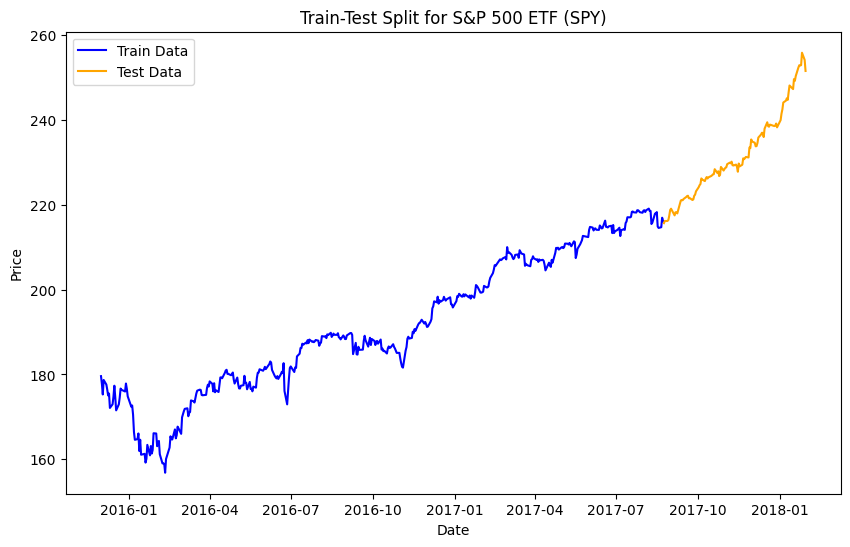

In [19]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Plot train and test data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='orange')
plt.title('Train-Test Split for S&P 500 ETF (SPY)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [21]:
# Function to check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

# Check stationarity of the closing prices
check_stationarity(train_data['Close'])

# If data is non-stationary, apply differencing
train_data['Close_diff'] = train_data['Close'].diff().dropna()

# Check stationarity again
check_stationarity(train_data['Close_diff'].dropna())

ADF Statistic: -0.23674215394139236
p-value: 0.9339979795783176
Critical Values: {'1%': np.float64(-3.44550760169756), '5%': np.float64(-2.868222645936761), '10%': np.float64(-2.5703296137102085)}
Data is non-stationary
ADF Statistic: -22.855465600702495
p-value: 0.0
Critical Values: {'1%': np.float64(-3.44550760169756), '5%': np.float64(-2.868222645936761), '10%': np.float64(-2.5703296137102085)}
Data is stationary


<ipython-input-21-5ff7ceb755cf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close_diff'] = train_data['Close'].diff().dropna()


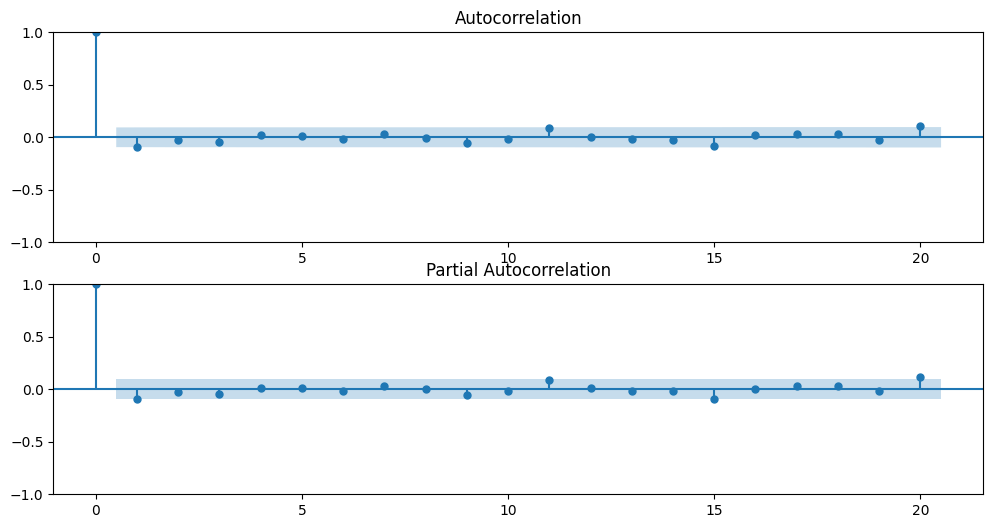

In [22]:
# Plot ACF and PACF for differenced data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(train_data['Close_diff'].dropna(), lags=20, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(train_data['Close_diff'].dropna(), lags=20, ax=plt.gca())
plt.show()

In [23]:
# Fit ARIMA model
model = ARIMA(data['Close'], order=(1, 1, 1))  # (p, d, q)
results = model.fit()

# Print model summary
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                  545
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -895.884
Date:                Mon, 17 Mar 2025   AIC                           1797.768
Time:                        18:42:04   BIC                           1810.665
Sample:                             0   HQIC                          1802.810
                                - 545                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1331      0.410      0.324      0.746      -0.671       0.937
ma.L1         -0.2099      0.411     -0.510      0.610      -1.016       0.596
sigma2         1.5774      0.066     23.886      0.0

<ipython-input-25-c2dc50152e30>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA_Predictions'] = test_predictions


MAE for ARIMA Model on Test Data: 0.7312191284433915


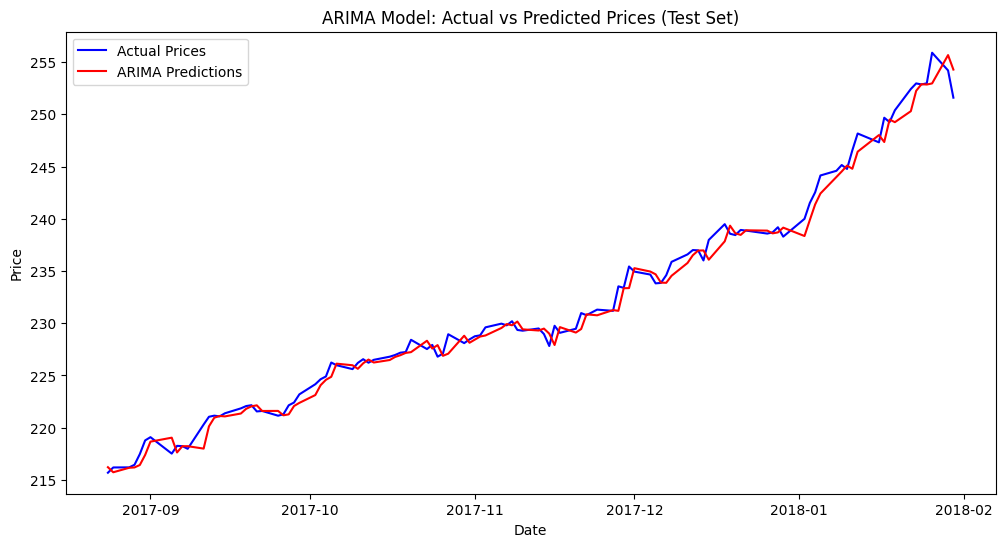

In [25]:
# Make predictions on the test data
test_predictions = results.predict(start=len(train_data), end=len(data)-1, typ='levels')

# Add predictions to the test data
test_data['ARIMA_Predictions'] = test_predictions

# Calculate MAE
mae_arima = mean_absolute_error(test_data['Close'], test_data['ARIMA_Predictions'])
print(f'MAE for ARIMA Model on Test Data: {mae_arima}')

# Plot actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual Prices', color='blue')
plt.plot(test_data.index, test_data['ARIMA_Predictions'], label='ARIMA Predictions', color='red')
plt.title('ARIMA Model: Actual vs Predicted Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
# Forecast future values (e.g., next 30 days)
future_steps = 30
future_forecast = results.forecast(steps=future_steps)

# Print the forecasted values
print("Future Forecasted Values:")
print(future_forecast)

Future Forecasted Values:
545    251.810609
546    251.839562
547    251.843414
548    251.843927
549    251.843995
550    251.844004
551    251.844005
552    251.844005
553    251.844005
554    251.844005
555    251.844005
556    251.844005
557    251.844005
558    251.844005
559    251.844005
560    251.844005
561    251.844005
562    251.844005
563    251.844005
564    251.844005
565    251.844005
566    251.844005
567    251.844005
568    251.844005
569    251.844005
570    251.844005
571    251.844005
572    251.844005
573    251.844005
574    251.844005
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
# Predict future values (e.g., next 30 days)
future_steps = 30
future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='B')[1:]  # Business days
future_predictions = results.predict(start=len(data), end=len(data) + future_steps - 1, typ='levels')

# Print the predicted values
print("Future Predicted Values:")
print(future_predictions)


Future Predicted Values:
545    251.810609
546    251.839562
547    251.843414
548    251.843927
549    251.843995
550    251.844004
551    251.844005
552    251.844005
553    251.844005
554    251.844005
555    251.844005
556    251.844005
557    251.844005
558    251.844005
559    251.844005
560    251.844005
561    251.844005
562    251.844005
563    251.844005
564    251.844005
565    251.844005
566    251.844005
567    251.844005
568    251.844005
569    251.844005
570    251.844005
571    251.844005
572    251.844005
573    251.844005
574    251.844005
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
